In [1]:
import os

In [2]:
from pydantic.v1 import BaseModel
from langgraph.graph import MessagesState,StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage,SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image,display
from typing import Annotated,TypedDict
from langchain_core.messages import AnyMessage
from dotenv import load_dotenv
load_dotenv()
from langchain_community.tools import DuckDuckGoSearchRun
import os
from langchain_groq import ChatGroq

In [3]:
GROQ_API_KEY=os.getenv('GROQ_API_KEY')
TAVILY_API_KEY=os.getenv("TANVILY_API_KEY")
os.environ['TAVILY_API_KEY']=TAVILY_API_KEY
os.environ['GROQ_API_KEY']=GROQ_API_KEY

In [4]:
llm=ChatGroq(model_name="Gemma2-9b-It")
llm.invoke("hii")

AIMessage(content='Hello! 👋  How can I help you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 10, 'total_tokens': 24, 'completion_time': 0.025454545, 'prompt_time': 3.7e-07, 'queue_time': 0.02399931, 'total_time': 0.025454915}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-ef8d4ef0-be99-49b1-9e66-35b8c09d2f1f-0', usage_metadata={'input_tokens': 10, 'output_tokens': 14, 'total_tokens': 24})

In [5]:
def multiply(a:int,b:int)-> int:
    """ Multiply a and b 
       Agrs:
            a: int
            b: int
    
    """
    return a * b

In [6]:
def add(a:int,b:int)->int:
    """Adds a and b.
       
       Args:
             a : The first int
             b : The second int   
    
    """

    return a + b

In [7]:
def divide(a:int,b:int)->float:
    """divide a and b.
       
       Args:
             a : The first int
             b : The second int   
    
    """

    return a / b

In [8]:
search=DuckDuckGoSearchRun()

In [26]:
search.run("who is the current president of USA?")

'The White House, official residence of the president of the United States, in July 2008. The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College. [2] The officeholder leads the executive branch of the federal government and is the commander-in-chief of the United States Armed ... Updated results from the 2024 election for the US president majority. Reuters live coverage of the 2024 US President, Senate, House and state governors races. Joe Biden is the 46th president of the United States (2021- ). He was born on November 20, 1942, in Scranton, Pennsylvania, and he served as a U.S. senator representing Delaware from 1972 to 2009. He was vice president in the Barack Obama administration from 2009 to 2017. In July 2024 Biden announced he would not seek a second term as president. The president of the United States is the: U.S. head of state; Chief executive of the federal gov

In [9]:
tools=[add,multiply,divide,search]

In [10]:
llm_with_tools=llm.bind_tools(tools)

In [11]:
#System message
sys_msg=SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [12]:
def reasoner(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state['messages'])]}

In [13]:

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

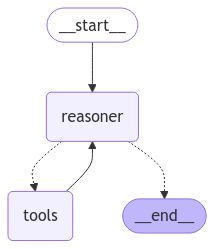

In [14]:

from IPython.display import Image, display
# View
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [15]:
message=[HumanMessage(content="What is 2 times of Narendra Modi's age ?")]

In [16]:
message=react_graph.invoke({"messages":message})

In [17]:
message

{'messages': [HumanMessage(content="What is 2 times of Narendra Modi's age ?", additional_kwargs={}, response_metadata={}, id='c9ab597f-8ec7-4f5d-a805-db95e42bfc6e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zc31', 'function': {'arguments': '{"query":"Narendra Modi\'s age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 1425, 'total_tokens': 1515, 'completion_time': 0.163636364, 'prompt_time': 0.045612129, 'queue_time': 0.003222560999999999, 'total_time': 0.209248493}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d77314bc-2dd0-4e8d-ae1e-5e6fbac4c57f-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': "Narendra Modi's age"}, 'id': 'call_zc31', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1425, 'output_tokens': 90, 'total_tokens': 1515}),
  ToolMessage(content="Error: Rate

In [36]:
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of Narendra Modi's age ?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_2wa6)
 Call ID: call_2wa6
  Args:
    query: Narendra Modi's age
================================= Tool Message =================================
Name: duckduckgo_search

Narendra Modi is the 14th prime minister of India. His Hindu nationalist policies and some of his economic reforms have proved controversial to many within and outside India. ... September 17, 1950, Vadnagar, India (age 74) (Show more) Also Known As: Narendra Damodardas Modi (Show more) Title / Office: prime minister (2014-), India (Show more ... PM Modi birthday is celebrated on September 17. He was the third child to be born to Hiraben and Damodardas Mulchand Modi. Narendra Modi Age. Narendra Modi, the present serving Prime Minister of India, was born on September 17, 1950. At p

In [18]:
messages = [HumanMessage(content="What is the result when you add 100 years to the current age of Elon Musk?")]
     

In [19]:

messages = react_graph.invoke({"messages": messages})

In [39]:
for m in messages['messages']:
    m.pretty_print()
     

================================ Human Message =================================

What is the result when you add 100 years to the current age of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  add (call_33az)
 Call ID: call_33az
  Args:
    a: 2023
    b: 100
================================= Tool Message =================================
Name: add

2123
================================== Ai Message ==================================

The result when you add 100 years to the current age of Elon Musk is 2123.
